In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from sklearn.metrics import *
import seaborn as sns
from sklearn.model_selection import *
import pickle
from sklearn.inspection import permutation_importance
import shap


c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cargar los datos
train = pd.read_csv('C:/Users/bvasquez/Desktop/Projects/2025/test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')
oot = pd.read_csv('C:/Users/bvasquez/Desktop/Projects/2025/test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')
prob = pd.read_csv('C:/Users/bvasquez/Desktop/Projects/2025/test/data/prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')
master = pd.read_csv('C:/Users/bvasquez/Desktop/Projects/2025/test/data/prueba_op_master_customer_data_enmascarado_completa.csv')
pagos = pd.read_csv('C:/Users/bvasquez/Desktop/Projects/2025/test/data/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv')
sample_sub = pd.read_csv('C:/Users/bvasquez/Desktop/Projects/2025/test/data/sample_submission.csv')


In [ ]:
# Mostrar dimensiones de cada set
shapes = pd.DataFrame({
    'Dataset': ['train', 'oot', 'prob', 'master', 'pagos'],
    'Rows': [train.shape[0], oot.shape[0], prob.shape[0], master.shape[0],pagos.shape[0]],
    'Columns': [train.shape[1], oot.shape[1], prob.shape[1], master.shape[1], pagos.shape[1]]
})
print("Dimensiones de los datasets:")
display(shapes)

# Inspección de columnas y primeras filas de train y master
print("\nColumnas de train:")
print(train.columns.tolist())
print("\nPrimeras 5 filas de train:")
display(train.head())

print("\nColumnas de prob:")
print(prob.columns.tolist())
print("\nPrimeras 5 filas de prob:")
display(prob.head())

print("\nColumnas de master:")
print(master.columns.tolist())
print("\nPrimeras 5 filas de master:")
display(master.head())

print("\nColumnas de pagos:")
print(pagos.columns.tolist())
print("\nPrimeras 5 filas de pagos:")
display(pagos.head())



Dimensiones de los datasets:


,Dataset,Rows,Columns
0,train,568251,49
1,oot,112549,4
2,prob,4804836,7
3,master,430000,37
4,pagos,4855035,13



Columnas de train:
['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt', 'var_rpta_alt', 'tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons', 'aplicativo', 'min_mora', 'max_mora', 'dias_mora_fin', 'rango_mora', 'vlr_obligacion', 'vlr_vencido', 'saldo_capital', 'endeudamiento', 'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3', 'cant_alter_posibles', 'alter_posible1_2', 'alter_posible2_2', 'alter_posible3_2', 'cant_gestiones', 'cant_gestiones_binario', 'rpc', 'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo', 'cant_acuerdo_binario', 'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult', 'marca_alt_rank', 'marca_alt_apli', 'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes', 'porc_pago_mes', 'pagos_tanque', 'marca_debito_mora', 'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'marca_pago', 'marca_alternativa', 'marca_alternativa_orig']

Primeras 5 filas de train:


,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,...,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig
0,630611,219718,863073,202308,1,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,...,0.095438,0.0,0.000000,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa
1,59412,789567,290775,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,NaN,Sin pago,NO,PRORROGA,MANTENIMIENTO,Sin pago,Acepta Alternativa,Acepta Alternativa
2,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,Acepta Alternativa,Acepta Alternativa
3,26897,585786,494556,202311,1,a_uno_tipo_1,Banca Personas,Personal,ROTATIVOS,Rotativos,...,0.042117,4090.0,0.015324,Con pago,NO,PRORROGA,MANTENIMIENTO,Pago parcial,Acepta Alternativa,Acepta Alternativa
4,24588,1061389,18953,202311,1,b_uno_tipo_2,Banca Personas,Personal plus,ROTATIVOS,Rotativos,...,0.000000,0.0,0.000000,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa



Columnas de prob:
['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte', 'lote', 'prob_propension', 'prob_alrt_temprana', 'prob_auto_cura']

Primeras 5 filas de prob:


,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura
0,296482,102381,202308,1,0.761350,0.193744,0.684784
1,391957,742315,202310,2,0.741803,0.384184,0.483696
2,229894,359919,202307,1,0.835373,0.285157,0.826225
3,478963,239064,202303,3,0.445002,0.629652,0.346508
4,349609,923348,202308,2,0.784365,0.419123,0.667603



Columnas de master:
['nit_enmascarado', 'cod_tipo_doc', 'tipo_cli', 'ctrl_terc', 'genero_cli', 'ano_nac_cli', 'edad_cli', 'estado_civil', 'tipo_vivienda', 'num_hijos', 'personas_dependientes', 'nivel_academico', 'ocup', 'act_econom', 'sector', 'subsector', 'declarante', 'total_ing', 'tot_activos', 'tot_pasivos', 'origen_fondos', 'f_vinc', 'f_ult_mantenimiento', 'canal_actualizacion', 'cli_actualizado', 'segm', 'subsegm', 'nicho', 'region_of', 'nombre_dpto_dirp', 'egresos_mes', 'tot_patrimonio', 'ciiu', 'smmlv', 'year', 'month', 'ingestion_day']

Primeras 5 filas de master:


,nit_enmascarado,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,...,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,year,month,ingestion_day
0,536377,1,PERSONA NATURAL,CLIENTE,F,1998.0,25.0,SOLTERO,FAMILIAR,0.0,...,MUJERES,CENTRO,SANTANDER,0.0,33750000.0,NaN,1160000.0,2023,12,31
1,512257,1,PERSONA NATURAL,CLIENTE,F,1984.0,38.0,UNION LIBRE,PROPIA,0.0,...,MUJERES,CARIBE,MAGDALENA,250000.0,5000000.0,ASALARIADOS,1160000.0,2023,9,30
2,5788,1,PERSONA NATURAL,CLIENTE SOCIAL,M,1960.0,63.0,NaN,NaN,0.0,...,NaN,DIRECCIÓN GENERAL,SIN INFORMACION,0.0,0.0,ASALARIADOS,1160000.0,2023,11,30
3,132245,1,PERSONA NATURAL,CLIENTE,F,1982.0,41.0,CASADO,NaN,1.0,...,MUJERES,SUR,VALLE,1000000.0,62513000.0,ASALARIADOS,1160000.0,2023,7,31
4,245279,1,PERSONA NATURAL,CLIENTE,M,1980.0,43.0,CASADO,ALQUILADA,0.0,...,NaN,BOGOTA Y CUNDINAMARCA,CALDAS,1000000.0,34135000.0,ASALARIADOS,1160000.0,2023,12,31



Columnas de pagos:
['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte', 'producto', 'aplicativo', 'segmento', 'valor_cuota_mes', 'pago_total', 'fecha_pago_minima', 'fecha_pago_maxima', 'porc_pago', 'marca_pago', 'ajustes_banco']

Primeras 5 filas de pagos:


,nit_enmascarado,num_oblig_enmascarado,fecha_corte,producto,aplicativo,segmento,valor_cuota_mes,pago_total,fecha_pago_minima,fecha_pago_maxima,porc_pago,marca_pago,ajustes_banco
0,482906,362297,20230731,CARTERA MICROCREDITO,L,MICROPYME,311950.0,1862788.0,20230621.0,20230721.0,597.0,PAGO_MENOS,NO
1,121735,186855,20230228,LIBRE INVERSION,L,SOCIAL,131030.0,264157.0,20230127.0,20230207.0,202.0,PAGO_MENOS,NO
2,582719,675503,20231031,TARJETA DE CREDITO,K,PERSONAL,1405339.0,3320.0,20231003.0,20231003.0,0.0,PAGO_MENOS,NO
3,299903,107931,20230228,ROTATIVOS,L,PERSONAL PLUS,19220.0,0.0,NaN,NaN,0.0,FACTURACION_MES_SGTE,NO
4,88625,566060,20230430,ROTATIVOS,L,PERSONAL,384684.0,769368.0,20230403.0,20230403.0,200.0,PAGO_MAS,NO


### Preparacion de los dataframes

In [4]:

# Train: convertir YYYYMM a última fecha del mes
train['fecha_var_rpta_dt'] = (
    pd.to_datetime(train['fecha_var_rpta_alt'].astype(str) + '01', format='%Y%m%d')
      + pd.offsets.MonthEnd(0)
)

# Prob: convertir YYYYMM a última fecha del mes
prob['fecha_corte_dt'] = (
    pd.to_datetime(prob['fecha_corte'].astype(str) + '01', format='%Y%m%d')
      + pd.offsets.MonthEnd(0)
)

# Pagos solo parsear 
pagos['fecha_corte_dt'] = pd.to_datetime(pagos['fecha_corte'], format='%Y%m%d')

# --- 5️⃣ Master: concatenar year, month, ingestion_day y parsear 
master['ingestion_date_dt'] = pd.to_datetime(
    master['year'].astype(str).str.zfill(4) +
    master['month'].astype(str).str.zfill(2) +
    master['ingestion_day'].astype(str).str.zfill(2),
    format='%Y%m%d'
)

# Verificación de que es fin de mes
master['is_month_end'] = master['ingestion_date_dt'] == master['ingestion_date_dt'] + pd.offsets.MonthEnd(0)

# Filtrar aquellos que NO sean fin de mes
not_eom = master[~master['is_month_end']]

# Mostrar ejemplos 
print("Train:", train[['fecha_var_rpta_alt','fecha_var_rpta_dt']].head(3))
print("Prob: ", prob[['fecha_corte','fecha_corte_dt']].head(3))
print("Pagos:", pagos[['fecha_corte','fecha_corte_dt']].head(3))
print("Master:", master[['year','month','ingestion_day','ingestion_date_dt','is_month_end']].head(3))
print('*'*100)
print("Número de registros que NO caen en fin de mes para master:", len(not_eom))



Train:    fecha_var_rpta_alt fecha_var_rpta_dt
0              202308        2023-08-31
1              202312        2023-12-31
2              202312        2023-12-31
Prob:     fecha_corte fecha_corte_dt
0       202308     2023-08-31
1       202310     2023-10-31
2       202307     2023-07-31
Pagos:    fecha_corte fecha_corte_dt
0     20230731     2023-07-31
1     20230228     2023-02-28
2     20231031     2023-10-31
Master:    year  month  ingestion_day ingestion_date_dt  is_month_end
0  2023     12             31        2023-12-31          True
1  2023      9             30        2023-09-30          True
2  2023     11             30        2023-11-30          True
****************************************************************************************************
Número de registros que NO caen en fin de mes para master: 0


In [5]:

# Agregado de probabilidades usando merge por 3 llaves
prob_ext = pd.merge(
    train[['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt']],
    prob[['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt',
          'prob_propension','prob_auto_cura','prob_alrt_temprana']],
    left_on = ['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt'],
    right_on= ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
    how='left'
)
# Ordenar para luego tomar .tail(3) dentro de cada grupo
prob_ext = prob_ext.sort_values(
    ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt']
)

# Agregaciones móviles de tamaño 3 (últimos 3 registros cronológicos)
prob_agg = (
    prob_ext
    .groupby(
        ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
        as_index=False
    )
    .agg(
        prop_mean3   = ('prob_propension',   lambda x: x.tail(3).mean()),
        atemp_mean3  = ('prob_alrt_temprana', lambda x: x.tail(3).mean()),
        auto_mean3   = ('prob_auto_cura',    lambda x: x.tail(3).mean()),
    )
)

# Merge final de estas nuevas features a tu train
train_feat = pd.merge(
    train,
    prob_agg,
    left_on = ['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt'],
    right_on= ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
    how='left').drop(columns=['fecha_corte_dt'])


# Agregaciones de pagos (3 meses) con merge
pag_ext = pd.merge(
    train_feat[['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt']],
    pagos[['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt','porc_pago']],
    left_on = ['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt'],
    right_on= ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
    how='left'
)

# Ordenar pag_ext para rolling
pag_ext = pag_ext.sort_values(
    ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'])

# Calcular media y conteo de los últimos 3 registros
pag_ext['pct_pago_mean_r3'] = (
    pag_ext
    .groupby(['nit_enmascarado','num_oblig_enmascarado'])['porc_pago']
    .transform(lambda x: x.rolling(3, min_periods=1).mean()))

pag_ext['pagos_count_r3'] = (
    pag_ext
    .groupby(['nit_enmascarado','num_oblig_enmascarado'])['porc_pago']
    .transform(lambda x: x.rolling(3, min_periods=1).count()))

# Definir pag_agg con las columnas de interés
pag_agg = pag_ext[[
    'nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt',
    'pct_pago_mean_r3','pagos_count_r3']].drop_duplicates()


# Merge final de pag_agg en train_feat
train_feat = pd.merge(
    train_feat,
    pag_agg,
    left_on = ['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt'],
    right_on= ['nit_enmascarado','num_oblig_enmascarado','fecha_corte_dt'],
    how='left'
).drop(columns=['fecha_corte_dt'])

# Merge de master en train_feat 
train_feat = train.merge(
    master,
    left_on=['nit_enmascarado'],
    right_on=['nit_enmascarado'],
    how='left'
)

# Eliminar decimales y convertir a string sin ".0"
train_feat['f_vinc_str']     = train_feat['f_vinc'].astype(str).str.replace(r'\.0$', '', regex=True)
train_feat['f_ult_str']      = train_feat['f_ult_mantenimiento'].astype(str).str.replace(r'\.0$', '', regex=True)

# Parsear fechas
train_feat['f_vinc_date']    = pd.to_datetime(train_feat['f_vinc_str'], format='%Y%m%d', errors='coerce')
train_feat['f_ult_date']     = pd.to_datetime(train_feat['f_ult_str'],  format='%Y%m%d', errors='coerce')

# Calcular años transcurridos
train_feat['years_since_vinc']     = abs(((train_feat['fecha_var_rpta_dt'] - train_feat['f_vinc_date']).dt.days / 365.25).round(2))
train_feat['years_since_ult_mant'] = abs(((train_feat['fecha_var_rpta_dt'] - train_feat['f_ult_date']).dt.days / 365.25).round(2))


In [6]:
# Validar duplicados
keys = ['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt']

# Contar registros por clave
counts = train_feat.groupby(keys).size().reset_index(name='count')

# Filtrar los que tienen más de una fila
duplicates = counts[counts['count'] > 1]

print(f"Número de claves duplicadas: {len(duplicates)}")
if not duplicates.empty:
    print("Primeros ejemplos de duplicados:")
    print(duplicates.head(10).to_string(index=False))
else:
    print("No hay duplicados por la llave compuesta.")

Número de claves duplicadas: 250725
Primeros ejemplos de duplicados:
 nit_enmascarado  num_oblig_orig_enmascarado  num_oblig_enmascarado  fecha_var_rpta_alt  count
               1                      975854                 104488              202308      4
               2                      389854                 690004              202312      2
              12                      623302                 457040              202312      2
              14                      209309                 873421              202308      2
              14                      209309                 873421              202310      2
              35                      184165                 903980              202310      2
              35                      719310                 361032              202310      2
              42                      975449                 104893              202309      3
              69                      621276                 459066         

In [7]:
# Ordenar descendente por ingestion_date_dt
train_feat = train_feat.sort_values(
    ['nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt','ingestion_date_dt'],
    ascending=[True, True, True, True, False]
)

# Drop duplicates dejando solo la primera (que es la de ingestion_date_dt más reciente)
keys = ['nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt']
train_feat = train_feat.drop_duplicates(subset=keys, keep='first')

# Verifica que ya no queden duplicados
dups = (
    train_feat
    .groupby(keys)
    .size()
    .loc[lambda s: s>1]
)
print("Cantidad de duplicados", len(dups)) 

Cantidad de duplicados 0


In [212]:
# Crear features para oot
# Definir llaves de identificación
keys = ['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado']

#  Extraer el último registro de train_feat según fecha
# Usamos idxmax para tomar la fila con máxima fecha_var_rpta_dt por grupo
last_idx = train_feat.groupby(keys)['fecha_var_rpta_dt'].idxmax()
train_latest = train_feat.loc[last_idx].reset_index(drop=True)

#  Merge left: mantenemos todas las filas de oot, trayendo features de train_latest
oot_merged = oot.merge(
    train_latest,
    on=keys,
    how='left'
)

#  Verificar shapes
print("train_feat (rows):", train_feat.shape[0])
print("train_latest (unique IDs):", train_latest.shape[0])
print("oot (rows):", oot.shape)
print("oot_merged (rows, cols):", oot_merged.shape)

# Mostrar primeras columnas y filas
print("\nEjemplo de oot_merged:")
print(oot_merged.head())

train_feat (rows): 568251
train_latest (unique IDs): 400807
oot (rows): (112549, 4)
oot_merged (rows, cols): (112549, 95)

Ejemplo de oot_merged:
   nit_enmascarado  num_oblig_orig_enmascarado  num_oblig_enmascarado  \
0           257335                      444821                 635511   
1            59584                      350400                 730364   
2           397604                      973821                 106521   
3           368086                      382995                 696856   
4           255009                      434238                 645924   

   fecha_var_rpta_alt_x  fecha_var_rpta_alt_y  var_rpta_alt tipo_var_rpta_alt  \
0                202401                   NaN           NaN               NaN   
1                202401                   NaN           NaN               NaN   
2                202401              202311.0           1.0      b_uno_tipo_2   
3                202401              202310.0           1.0      a_uno_tipo_1   
4         

In [110]:
# Filtrar train_feat df
last_month = train_feat['fecha_var_rpta_alt'].max()

# Filtra todas las filas de ese mes
last_month = train_feat['fecha_var_rpta_alt'].max()
print("Último mes disponible (YYYYMM):", last_month)

# Separa df_train
df_train_valid = train_feat[train_feat['fecha_var_rpta_alt'] < last_month].reset_index(drop=True)
df_train_valid.shape

Último mes disponible (YYYYMM): 202312


(467785, 94)

### EDA

Porcentaje de valores faltantes (top 25):
tipo_vivienda               0.737161
nivel_academico             0.640018
alternativa_aplicada_agr    0.635944
marca_agrupada_rgo          0.635942
nicho                       0.620161
alter_posible3_2            0.604476
alter_posible2_2            0.587817
porc_pago_mes               0.555565
canal_actualizacion         0.274868
estado_civil                0.258279
subsector                   0.248338
ciiu                        0.248338
sector                      0.248338
act_econom                  0.246102
ocup                        0.239219
subsegm                     0.219896
genero_cli                  0.217467
personas_dependientes       0.217440
edad_cli                    0.217437
ano_nac_cli                 0.217437
num_hijos                   0.217437
origen_fondos               0.204870
nombre_dpto_dirp            0.199252
declarante                  0.197106
segm                        0.196858
dtype: float64

Número de valores

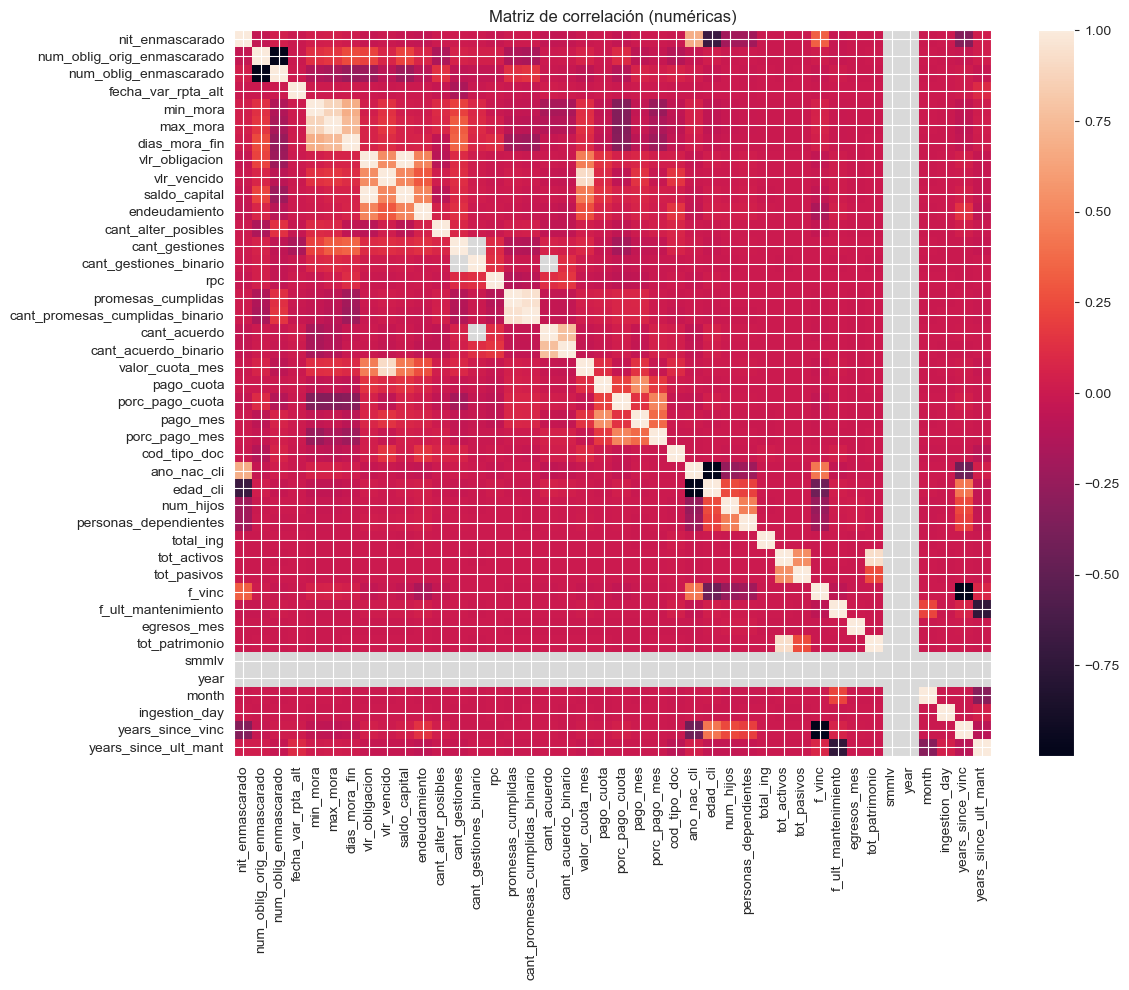


Pares de variables con |correlación| > 0.5:
num_oblig_enmascarado ↔ num_oblig_orig_enmascarado: -1.00
max_mora ↔ min_mora: 0.88
dias_mora_fin ↔ min_mora: 0.69
dias_mora_fin ↔ max_mora: 0.74
vlr_vencido ↔ vlr_obligacion: 0.53
saldo_capital ↔ vlr_obligacion: 1.00
saldo_capital ↔ vlr_vencido: 0.51
cant_promesas_cumplidas_binario ↔ promesas_cumplidas: 0.95
cant_acuerdo_binario ↔ cant_acuerdo: 0.77
valor_cuota_mes ↔ vlr_vencido: 0.92
pago_mes ↔ pago_cuota: 0.54
ano_nac_cli ↔ nit_enmascarado: 0.69
edad_cli ↔ nit_enmascarado: -0.69
edad_cli ↔ ano_nac_cli: -1.00
tot_pasivos ↔ tot_activos: 0.54
tot_patrimonio ↔ tot_activos: 0.93
years_since_vinc ↔ f_vinc: -1.00
years_since_ult_mant ↔ f_ult_mantenimiento: -0.74


In [111]:
#EDA en df_train_valid
df = df_train_valid

# Porcentaje de valores faltantes
missing_pct = df.isna().mean().sort_values(ascending=False)
print("Porcentaje de valores faltantes (top 25):")
print(missing_pct.head(25))

# Cardinalidad de variables
unique_counts = df.nunique().sort_values(ascending=False)
print("\nNúmero de valores únicos (top 20):")
print(unique_counts.head(20))

# Estadísticas descriptivas numéricas
print("\nEstadísticas descriptivas (numéricas):")
print(df.describe().T.head(20))

# Matriz de correlación numérica
num_feats = df.select_dtypes(include=[np.number]).drop(columns=['var_rpta_alt'], errors='ignore')
corr = num_feats.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (numéricas)")
plt.tight_layout()
plt.show()

# Pares con alta correlación (>0.5)
threshold_corr = 0.5
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold_corr:
            high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
print("\nPares de variables con |correlación| > 0.5:")
for var1, var2, val in high_corr:
    print(f"{var1} ↔ {var2}: {val:.2f}")

In [112]:
# Eliminacion de variables por inspeccion 
cols_to_drop = [
    'smmlv', 'year', 'month', 'ingestion_day', 'ingestion_date_dt',
    'is_month_end', 'f_vinc_str', 'f_ult_str', 'f_vinc_date', 'f_ult_date',
    'f_vinc', 'f_ult_mantenimiento', 'ano_nac_cli', 'min_mora', 'max_mora',
    'num_oblig_orig_enmascarado', 'vlr_obligacion', 'cant_promesas_cumplidas_binario',
    'cant_acuerdo_binario', 'valor_cuota_mes', 'tot_patrimonio','tipo_var_rpta_alt',
    'banca', 'segmento', 'producto', 'producto_cons','rango_mora','desc_alternativa1',
    'desc_alternativa2','desc_alternativa3','cant_alter_posibles','alter_posible1_2',
    'descripcion_ranking_mejor_ult','descripcion_ranking_post_ult','marca_alt_rank', 
    'marca_alt_apli','marca_alternativa','marca_alternativa_orig','fecha_var_rpta_alt', 
    'cod_tipo_doc','tipo_cli', 'ctrl_terc','cant_gestiones_binario','cli_actualizado', 
    'segm', 'subsegm', 'region_of','origen_fondos','nombre_dpto_dirp','aplicativo'
]

# Eliminar de train_valid
df_train_valid = df_train_valid.drop(columns=cols_to_drop, errors='ignore')

# Verifica
print("Nuevo shape:", df_train_valid.shape)

Nuevo shape: (467785, 44)


In [113]:
# Eliminar columnas alto faltantes
threshold_miss = 0.22
cols_to_drop = missing_pct[missing_pct > threshold_miss].index.tolist()
print(f"Columnas a eliminar (> {threshold_miss*100:.0f}% missing):")
print(cols_to_drop)

# Eliminar columnas del DataFrame
df_train_valid.drop(columns=cols_to_drop, inplace=True)

# Verificar nueva forma y porcentaje de missing restante
print("\nNueva forma:", df_train_valid.shape)
print("Top 10 valores faltantes tras drop:")
print(df_train_valid.isna().mean().sort_values(ascending=False).head(10))

Columnas a eliminar (> 22% missing):
['tipo_vivienda', 'nivel_academico', 'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'nicho', 'alter_posible3_2', 'alter_posible2_2', 'porc_pago_mes', 'canal_actualizacion', 'estado_civil', 'subsector', 'ciiu', 'sector', 'act_econom', 'ocup']

Nueva forma: (467785, 29)
Top 10 valores faltantes tras drop:
genero_cli               0.217467
personas_dependientes    0.217440
num_hijos                0.217437
edad_cli                 0.217437
declarante               0.197106
years_since_ult_mant     0.196849
years_since_vinc         0.196849
egresos_mes              0.196849
tot_pasivos              0.196849
tot_activos              0.196849
dtype: float64


In [114]:
# Identificar variables categóricas
cat_feats = df_train_valid.select_dtypes(include=['object','category']).columns.tolist()

# Calcular y mostrar cardinalidades
cardinalities = {col: df_train_valid[col].nunique() for col in cat_feats}

print("Cardinalidad de variables categóricas:")
for feat, card in sorted(cardinalities.items(), key=lambda x: -x[1]):
    print(f"{feat}: {card}")

Cardinalidad de variables categóricas:
marca_pago: 4
pagos_tanque: 2
marca_debito_mora: 2
genero_cli: 2
declarante: 2


In [115]:
# Variables categóricas binarias a transformar
binary_vars = ['pagos_tanque', 'marca_debito_mora', 'genero_cli', 'declarante']

# Factorizar cada una para crear columna _bin
for var in binary_vars:
    codes, uniques = pd.factorize(df_train_valid[var])
    df_train_valid[f"{var}_bin"] = codes
# Eliminar variables categóricas originales
df_train_valid.drop(columns=binary_vars, inplace=True)

# Codificación específica para marca_pago
mapping = {
    'Sin pago': 0,
    'Pago parcial': 1,
    'Cumple compromiso': 2,
    'Pago Total': 3
}
df_train_valid['marca_pago_enc'] = df_train_valid['marca_pago'].map(mapping)
df_train_valid.drop(columns=['marca_pago'], inplace=True)

# Verificar resultados
print("Shape df ")
print(df_train_valid.shape)
print("Nuevas columnas binarias y codificadas:")
print([col for col in df_train_valid.columns if col.endswith('_bin') or col == 'marca_pago_enc'])

print("\nEjemplo de codificaciones (primeras filas):")
print(df_train_valid[['pagos_tanque_bin','marca_debito_mora_bin',
                      'genero_cli_bin','declarante_bin','marca_pago_enc']].head())

Shape df 
(467785, 29)
Nuevas columnas binarias y codificadas:
['pagos_tanque_bin', 'marca_debito_mora_bin', 'genero_cli_bin', 'declarante_bin', 'marca_pago_enc']

Ejemplo de codificaciones (primeras filas):
   pagos_tanque_bin  marca_debito_mora_bin  genero_cli_bin  declarante_bin  \
0                 0                      0               0               0   
1                 1                      0               1               0   
2                 1                      0               0               0   
3                 1                      0               0               0   
4                 1                      0               0               1   

   marca_pago_enc  
0               1  
1               2  
2               0  
3               0  
4               0  


In [116]:
# Variable imputation
cols_to_impute = [  
                    'cant_gestiones','cant_acuerdo', 'pago_cuota','rpc',
                    'edad_cli', 'num_hijos', 'personas_dependientes',
                    'total_ing', 'tot_activos', 'tot_pasivos',
                    'egresos_mes', 'years_since_vinc', 'years_since_ult_mant'
                  ]

#Multiple imputation by Chain equation
imputer = IterativeImputer(max_iter=10,random_state=42)
df_train_valid[cols_to_impute] = imputer.fit_transform(df_train_valid[cols_to_impute])

#Round days to the nearest int
columns_to_round = [
                  'cant_gestiones', 'cant_acuerdo', 'pago_cuota', 'edad_cli','rpc', 
                  'num_hijos', 'personas_dependientes', 'total_ing', 
                  'tot_activos', 'tot_pasivos', 'egresos_mes'
                    ]       

for column in columns_to_round:
  df_train_valid[column] = df_train_valid[column].round().astype('Int64')


#Display imputation
print(df_train_valid)
print(df_train_valid.isna().sum())

        nit_enmascarado  num_oblig_enmascarado  var_rpta_alt  dias_mora_fin  \
0                     1                 104488             1              0   
1                     5                 621619             1              0   
2                    14                 873421             0             27   
3                    14                 873421             0             29   
4                    21                 994106             0             16   
...                 ...                    ...           ...            ...   
467780           634695                 633420             0             16   
467781           634700                 360773             0             19   
467782           634701                 599438             0             17   
467783           634707                 954483             0             43   
467784           634709                 780082             0             56   

        vlr_vencido  saldo_capital  endeudamiento  

In [134]:
# Separate Original DataFrame in train and validate, rows that appear in training data do not appear in validation data
df_unique_ids = df_train_valid['nit_enmascarado'].unique().copy()

# Split the unique IDs into training and validation sets
train_ids, valid_ids = train_test_split(df_unique_ids, test_size= 0.25, random_state = 42)

# Define the training and validation datasets based on split IDs
df_train = df_train_valid[df_train_valid['nit_enmascarado'].isin(train_ids)].select_dtypes(include=['number']).copy()
df_valid = df_train_valid[df_train_valid['nit_enmascarado'].isin(valid_ids)].select_dtypes(include=['number']).copy()

df_train['date']= df_train_valid['fecha_var_rpta_dt']
df_valid['date']= df_train_valid['fecha_var_rpta_dt']


# Define training and validation time 
train_start_date = '2023-08-31'
train_end_date = '2023-10-31'
valid_start_date = '2023-10-31'
valid_end_date = '2024-11-30'

# Filter DataFrame based on time periods
df_train = df_train[(df_train['date']>=train_start_date) & (df_train['date']<train_end_date)].copy()
df_valid = df_valid[(df_valid['date']>=valid_start_date)].copy()

In [135]:
# Extract from validation data set some obligationas that allow us to evaluate performance of the model 
df_ids_unicos_valid = df_valid.nit_enmascarado.unique().copy()
# Testing set ids
test_size_valid = 0.75
random_state_valid = 1234
id_valid1,id_test = train_test_split(df_ids_unicos_valid,test_size = test_size_valid,random_state = random_state_valid)

In [136]:
df_train_id = df_train
df_valid_id = df_valid

In [164]:
# Definir variables de train/valid
df_train = df_train[[ 
    'var_rpta_alt', 
    'dias_mora_fin',
    'marca_pago_enc',
    'pagos_tanque_bin',
    'cant_acuerdo',
    'rpc',
    'pago_mes',
    'promesas_cumplidas',
    'cant_gestiones',
    'endeudamiento',
    'porc_pago_cuota'
]]


df_valid = df_valid[[
    'var_rpta_alt', 
    'dias_mora_fin',
    'marca_pago_enc',
    'pagos_tanque_bin',
    'cant_acuerdo',
    'rpc',
    'pago_mes',
    'promesas_cumplidas',
    'cant_gestiones',
    'endeudamiento',
    'porc_pago_cuota'
]]

In [165]:
# Base model
# Prepare the data for training
X_train = df_train.drop(columns=['var_rpta_alt'])
y_train = df_train['var_rpta_alt']

# Prepare the data for validation 
X_valid = df_valid.drop(columns=['var_rpta_alt'])
y_valid = df_valid['var_rpta_alt']

# Train the model
model = RandomForestClassifier()
model.fit(X_train,y_train)

# Evaluate model
y_pred = model.predict(X_valid)

# Calculate F1 Score
f1 = f1_score(y_valid,y_pred)

# Display the results
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion_matrix(y_valid,y_pred))
print("Classification Report:\n", classification_report(y_valid,y_pred))

F1 Score: 0.8060199469039248
Confusion Matrix:
 [[25013  5182]
 [ 5632 22467]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.82     30195
           1       0.81      0.80      0.81     28099

    accuracy                           0.81     58294
   macro avg       0.81      0.81      0.81     58294
weighted avg       0.81      0.81      0.81     58294



In [166]:
#Curve for uncalibrated model
fraction_of_positives, mean_predicted_value = calibration_curve(y_valid,y_pred, n_bins=20)
y_pred_pro = model.predict_proba(X_valid)[:,1]

Predictive Capacity of the Baseline model
__________________________________________________________________________________________
F-Score: 0.80602
Baseline Model Performance
               precision    recall  f1-score   support

           0       0.82      0.83      0.82     30195
           1       0.81      0.80      0.81     28099

    accuracy                           0.81     58294
   macro avg       0.81      0.81      0.81     58294
weighted avg       0.81      0.81      0.81     58294

Baseline ROC AUC Score:
 0.8139740016641299
__________________________________________________________________________________________


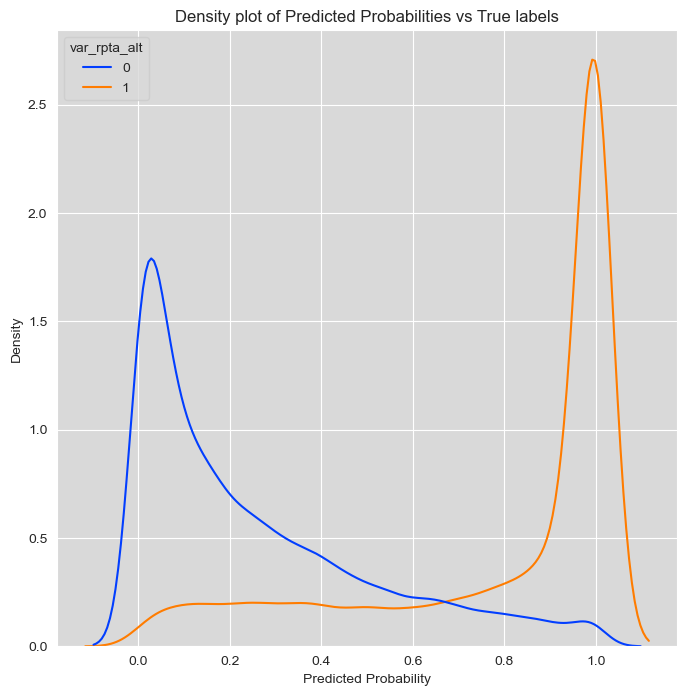

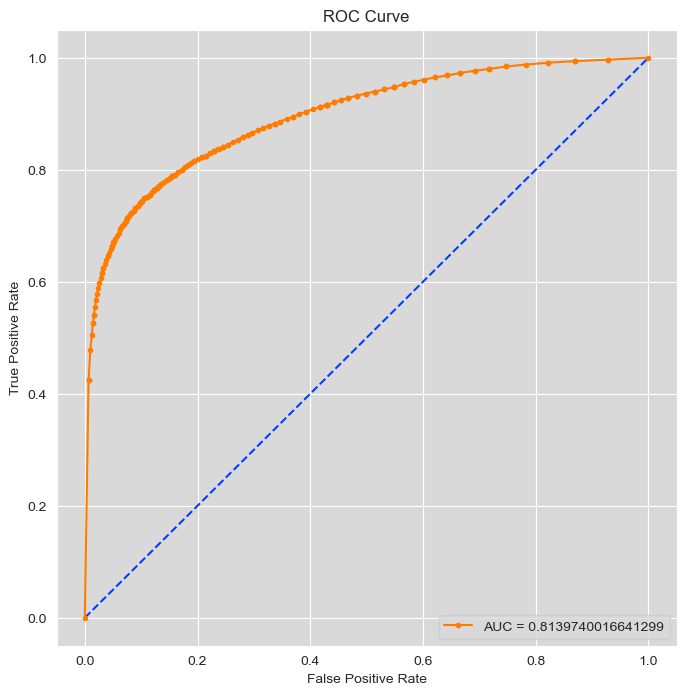

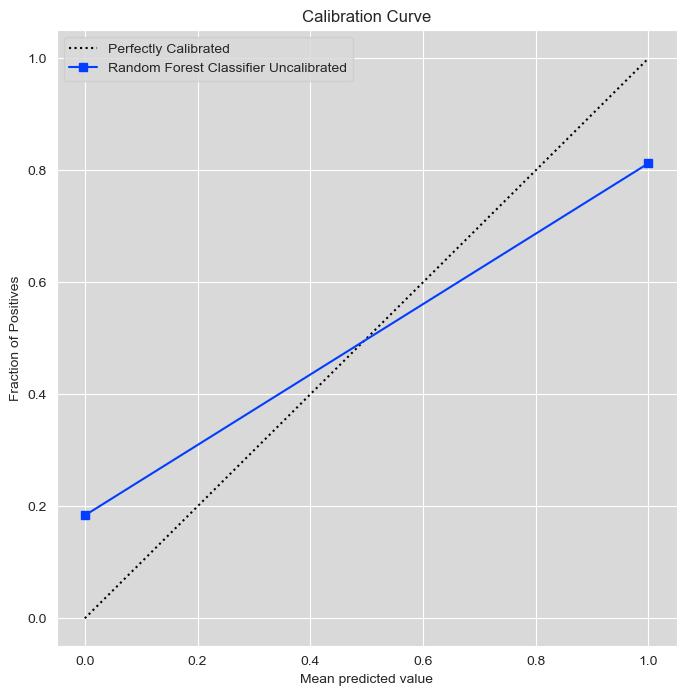

In [167]:
# Evaluate the model predictive capacity
print("Predictive Capacity of the Baseline model")
print("_"*90)
score = f1_score(y_valid, y_pred)
print('F-Score: %.5f' % score)
print("Baseline Model Performance\n", classification_report(y_valid,y_pred))
print("Baseline ROC AUC Score:\n", roc_auc_score(y_valid,y_pred))
print("_"*90)

# Discriminant Capacity
sns.set_palette("bright",3)
sns.set_style("darkgrid", {"axes.facecolor": ".85"})
plt.figure(figsize=(8,8))
sns.kdeplot(x=y_pred_pro, hue=y_valid)
plt.title("Density plot of Predicted Probabilities vs True labels")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.show()

false_pos_rate, true_pos_rate, proba = roc_curve(y_valid, y_pred_pro)
plt.figure(figsize=(8,8))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_valid,y_pred)}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

#Calibration Curve
plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1], "k:", label = "Perfectly Calibrated")
plt.plot(mean_predicted_value,fraction_of_positives, "s-", label="Random Forest Classifier Uncalibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()


# Fine Tunning and Optimize model

In [168]:
# Fine tunning the model
false_positive = np.logical_and(y_valid != y_pred, y_pred == 1)
false_negative = np.logical_and(y_valid != y_pred, y_pred == 0)


x_valid_fn = X_valid[false_negative]
x_valid_fp = X_valid[false_positive]

print(x_valid_fn.shape)
print(x_valid_fp.shape)

# Threshold optimization
optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_pred_pro]
print(optimal_proba_cutoff)

(5632, 10)
(5182, 10)
0.6539999999999999


In [170]:
# Naming for trained models
TAG = "FINAL_V1_PP_RF"

In [171]:
# Parameter definition for modeling
param_grid = {'bootstrap': [True],
              'max_depth': [48,None],
              'max_features': ['sqrt'],
              'min_samples_leaf': [1000,2000],
              'min_samples_split': [50,100,200],
              'n_estimators': [16,32,64,128],
              'oob_score' : [True]}

# Number of experiments in modeling 
NUM_TRIALS = 3

# Arrays to store scores
outer_scores = np.zeros(NUM_TRIALS)
inner_scores = np.zeros(NUM_TRIALS)

# Evaluation metrics for modeling
scoring = {"AUC": "roc_auc",
           "balanced_accuracy": make_scorer(balanced_accuracy_score)}

class_weights = dict([x for x in zip([1,0], list((y_train.value_counts()/y_train.shape[0]).values))])

# CV Loops definitions
inner_cv_groups = df_train_id['nit_enmascarado']
outer_cv_groups = df_valid_id['nit_enmascarado']

In [172]:
# Codigo modelación
import time
inner_models = list()
inner_models = list()
for i in range(NUM_TRIALS):
    inner_cv = GroupKFold(n_splits = 3) 
    outer_cv = GroupKFold(n_splits = 3)
    
    inner_cv_indexes = list(inner_cv.split(X_train, 
                                           y_train, 
                                           inner_cv_groups))      
    
    # nested parameter search and scoring
    base_estimator = RandomForestClassifier(random_state=i,class_weight=class_weights, n_jobs=-1)
    
    inner_clf = RandomizedSearchCV(estimator=base_estimator, 
                               param_distributions = param_grid,
                               cv = inner_cv_indexes, 
                               n_iter = 10,
                               scoring = "roc_auc_ovr",
                               refit = True,
                               return_train_score = True,
                               random_state = i,
                               n_jobs = 1)
    
    print("inner cv: ", i)
    inner_start = time.time()
    inner_clf.fit(X_train, y_train)
    inner_end = time.time()
    print("inner elapsed: {}".format(inner_end-inner_start))
    inner_scores[i] = inner_clf.best_score_

    
   #save inner_scores
    fname_inner_score = "{}_inner_score_trial_{}_{}".format(TAG, i,".sav")
    with open(fname_inner_score, "wb") as f:
        pickle.dump(inner_clf.best_score_, f)


   # save inner_model
    fname_inner_model = "{}_inner_model_trial_{}_{}".format(TAG, i,".sav")
    with open(fname_inner_model, "wb") as f:
        pickle.dump(inner_clf.best_estimator_, f)
 
    inner_models.append(inner_clf.best_estimator_)
 
    print("outer_cv: ", i)
    outer_start = time.time()
    outer_clf = cross_val_score(inner_clf.best_estimator_, 
                                X = X_valid, 
                                y = y_valid, 
                                cv=outer_cv,
                                groups = outer_cv_groups,
                                scoring = "f1",
                                n_jobs = 1)
    outer_end = time.time()
    print("outer elapsed: {}".format(outer_end-outer_start))
    outer_scores[i] = outer_clf.mean()
    
    print("inner score: {}".format(inner_clf.best_score_))
    print("outer score: {}".format( outer_clf.mean()))
    print('-'*90)
   # save iouter_score
    fname_outer_score = "{}_outer_score_trial_{}_{}".format(TAG, i,".sav")
    with open(fname_outer_score, "wb") as f:
        pickle.dump(outer_clf.mean(), f)

inner cv:  0


c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasque

inner elapsed: 33.08267426490784
outer_cv:  0
outer elapsed: 2.4540867805480957
inner score: 0.916121675910075
outer score: 0.7869730372582131
------------------------------------------------------------------------------------------
inner cv:  1


c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasque

inner elapsed: 44.6951858997345
outer_cv:  1
outer elapsed: 2.3960189819335938
inner score: 0.9160497534503614
outer score: 0.7842384282605724
------------------------------------------------------------------------------------------
inner cv:  2


c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasquez\AppData\Local\anaconda3\envs\contact\lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bvasque

inner elapsed: 38.669302225112915
outer_cv:  2
outer elapsed: 2.3728559017181396
inner score: 0.9156659978751146
outer score: 0.7838161968884808
------------------------------------------------------------------------------------------


In [173]:
# Get the best model of the cross validation loop
harmonic = 2*(inner_scores*outer_scores)/(inner_scores + outer_scores)
best_model_id =np.argmax(harmonic)
best_model= inner_models[best_model_id]

best_model_params = best_model.get_params()
print(best_model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {1: 0.5105429685292955, 0: 0.4894570314707046}, 'criterion': 'gini', 'max_depth': 48, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1000, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 128, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [174]:
# Gini Importance
feature_names = X_valid.keys().tolist()

gini_importance = best_model.feature_importances_
gini_df = pd.DataFrame({'Feature': feature_names, 'Importance': gini_importance})
gini_df = gini_df.sort_values(by='Importance', ascending=False)

# Permutation Importance
perm_importance = permutation_importance(best_model, X_valid, y_valid, n_repeats=20, random_state=42)
perm_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean})
perm_df = perm_df.sort_values(by='Importance', ascending=False)

print("Gini Importance:\n", gini_df)
print("\nPermutation Importance:\n", perm_df)

Gini Importance:
               Feature  Importance
0       dias_mora_fin    0.317859
1      marca_pago_enc    0.265924
5            pago_mes    0.107308
3        cant_acuerdo    0.086118
2    pagos_tanque_bin    0.070699
4                 rpc    0.056205
6  promesas_cumplidas    0.041515
7      cant_gestiones    0.027809
8       endeudamiento    0.017258
9     porc_pago_cuota    0.009304

Permutation Importance:
               Feature  Importance
0       dias_mora_fin    0.127960
1      marca_pago_enc    0.098667
7      cant_gestiones    0.023142
4                 rpc    0.019341
3        cant_acuerdo    0.010915
8       endeudamiento    0.007136
5            pago_mes    0.005656
6  promesas_cumplidas    0.003276
9     porc_pago_cuota    0.002106
2    pagos_tanque_bin    0.000823


#### El Gini importance y el permutation importance determino que varias variables no estaban afectando el modelo por ende fueron sustraidas para mejor explicabilidad del modelo. Modelo inicial de 25 variables y modelo final de 10 variables.

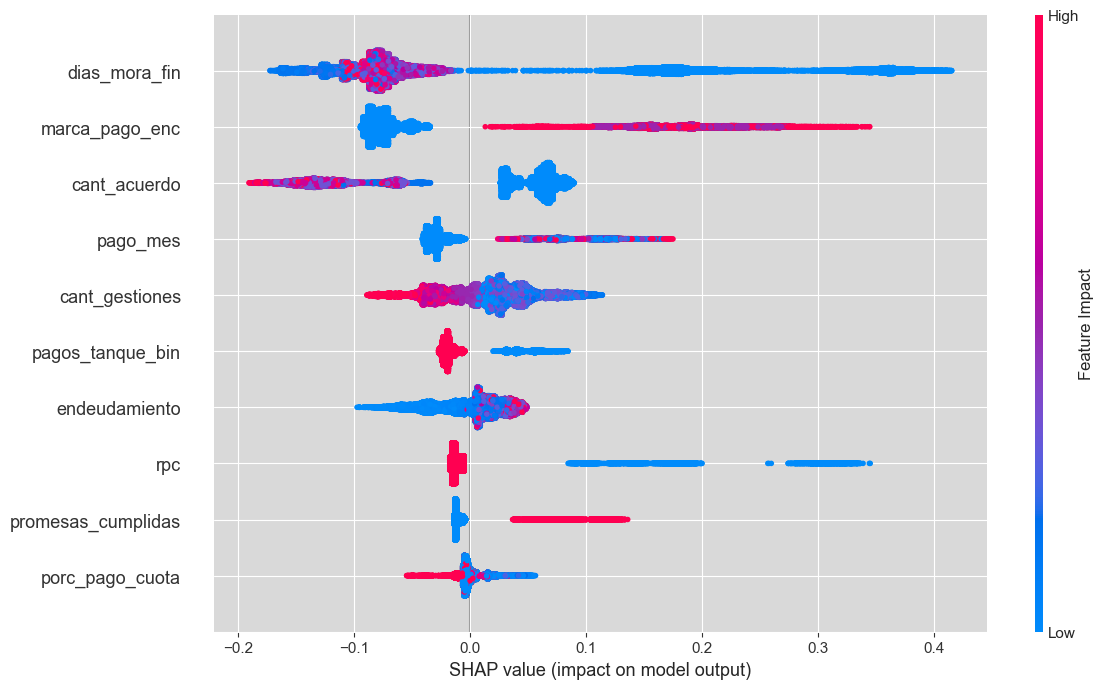

In [175]:
# Initialize explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP value
shap_value = explainer.shap_values(X_valid)

# Visualization 
shap.summary_plot(
    shap_value[:, :, 1], 
    X_valid,  
    title='Customized SHAP Summary Plot', 
    color_bar_label='Feature Impact',
    plot_size=(12, 7)
)

## Predictions

In [213]:
# Variables categóricas binarias a transformar
binary_vars = ['pagos_tanque', 'marca_debito_mora', 'genero_cli', 'declarante']

# Factorizar cada una para crear columna _bin
for var in binary_vars:
    codes, uniques = pd.factorize(oot_merged[var])
    oot_merged[f"{var}_bin"] = codes

# Transformar -1 a 0
oot_merged.replace({-1: 0}, inplace=True)

# Eliminar variables categóricas originales
oot_merged.drop(columns=binary_vars, inplace=True)

# Codificación específica para marca_pago
mapping = {
    'Sin pago': 0,
    'Pago parcial': 1,
    'Cumple compromiso': 2,
    'Pago Total': 3
}
oot_merged['marca_pago_enc'] = oot_merged['marca_pago'].map(mapping)
oot_merged.drop(columns=['marca_pago'], inplace=True)

# Verificar resultados
print("Shape df ")
print(oot_merged.shape)
print("Nuevas columnas binarias y codificadas:")
print([col for col in oot_merged.columns if col.endswith('_bin') or col == 'marca_pago_enc'])

print("\nEjemplo de codificaciones (primeras filas):")
print(oot_merged[['pagos_tanque_bin','marca_debito_mora_bin',
                      'genero_cli_bin','declarante_bin','marca_pago_enc']].head())

Shape df 
(112549, 95)
Nuevas columnas binarias y codificadas:
['pagos_tanque_bin', 'marca_debito_mora_bin', 'genero_cli_bin', 'declarante_bin', 'marca_pago_enc']

Ejemplo de codificaciones (primeras filas):
   pagos_tanque_bin  marca_debito_mora_bin  genero_cli_bin  declarante_bin  \
0                 0                      0               0               0   
1                 0                      0               0               0   
2                 0                      0               0               0   
3                 1                      1               1               0   
4                 0                      0               0               0   

   marca_pago_enc  
0             NaN  
1             NaN  
2             0.0  
3             1.0  
4             0.0  


In [214]:
# Variable imputation
cols_to_impute = [  
                    'dias_mora_fin',
    'marca_pago_enc',
    'cant_acuerdo',
    'rpc',
    'pago_mes',
    'promesas_cumplidas',
    'cant_gestiones',
    'endeudamiento',
    'porc_pago_cuota'
                  ]

#Multiple imputation by Chain equation
imputer = IterativeImputer(max_iter=10,random_state=42)
oot_merged[cols_to_impute] = imputer.fit_transform(oot_merged[cols_to_impute])

#Round days to the nearest int
columns_to_round = [
                  'cant_gestiones', 'cant_acuerdo', 'pago_cuota', 'edad_cli','rpc', 
                  'num_hijos', 'personas_dependientes', 'total_ing', 
                  'tot_activos', 'tot_pasivos', 'egresos_mes','pagos_tanque_bin'
                    ]       

for column in columns_to_round:
  oot_merged[column] = oot_merged[column].round().astype('Int64')



#Display imputation
print(oot_merged)
print(oot_merged.isna().sum())

        nit_enmascarado  num_oblig_orig_enmascarado  num_oblig_enmascarado  \
0                257335                      444821                 635511   
1                 59584                      350400                 730364   
2                397604                      973821                 106521   
3                368086                      382995                 696856   
4                255009                      434238                 645924   
...                 ...                         ...                    ...   
112544           316499                       14503                1074624   
112545           254311                       30479                1013957   
112546           483193                       13732                1006779   
112547           293824                       22004                1062743   
112548           310206                       28886                 885408   

        fecha_var_rpta_alt_x  fecha_var_rpta_alt_y  var_rpta_al

In [215]:

model_train_valid = RandomForestClassifier()
model_train_valid.set_params(**best_model_params)
X_train_valid = pd.concat([X_train, X_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)
model_train_valid.fit(X_train_valid,y_train_valid)

RandomForestClassifier(class_weight={0: 0.4894570314707046,
                                     1: 0.5105429685292955},
                       max_depth=48, min_samples_leaf=1000,
                       min_samples_split=100, n_estimators=128, n_jobs=-1,
                       oob_score=True, random_state=0)

In [216]:
best_model = model_train_valid
print(best_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {1: 0.5105429685292955, 0: 0.4894570314707046}, 'criterion': 'gini', 'max_depth': 48, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1000, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 128, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [217]:
test = oot_merged[['dias_mora_fin',
    'marca_pago_enc',
    'pagos_tanque_bin',
    'cant_acuerdo',
    'rpc',
    'pago_mes',
    'promesas_cumplidas',
    'cant_gestiones',
    'endeudamiento',
    'porc_pago_cuota']]


In [218]:
oot_merged['prediction'] = best_model.predict(test)
oot_merged['probability'] = best_model.predict_proba(test)[:,1]

In [219]:
oot_merged

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt_x,fecha_var_rpta_alt_y,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,...,f_ult_date,years_since_vinc,years_since_ult_mant,pagos_tanque_bin,marca_debito_mora_bin,genero_cli_bin,declarante_bin,marca_pago_enc,prediction,probability
0,257335,444821,635511,202401,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,0,0,0,0,0.321626,1,0.581394
1,59584,350400,730364,202401,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,0,0,0,0,0.321626,1,0.581394
2,397604,973821,106521,202401,202311.0,1.0,b_uno_tipo_2,Banca Personas,Personal plus,CARTERA MICROCREDITO,...,2023-09-15,10.47,0.21,0,0,0,0,0.000000,1,0.592820
3,368086,382995,696856,202401,202310.0,1.0,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,...,2023-12-19,7.69,0.13,1,1,1,0,1.000000,1,0.943281
4,255009,434238,645924,202401,202310.0,0.0,e_cero_tipo_2,Independientes,Micropyme,TARJETA DE CREDITO,...,NaT,NaN,NaN,0,0,0,0,0.000000,0,0.295611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112544,316499,14503,1074624,202401,202312.0,1.0,b_uno_tipo_2,Banca Pyme,Pymes,TARJETA DE CREDITO,...,2023-11-29,2.92,0.09,0,0,0,1,0.000000,0,0.229210
112545,254311,30479,1013957,202401,202311.0,0.0,e_cero_tipo_2,Independientes,Micropyme,TARJETA DE CREDITO,...,2023-09-27,24.43,0.18,0,0,1,0,0.000000,1,0.645007
112546,483193,13732,1006779,202401,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,0,0,0,0,0.321626,1,0.581394
112547,293824,22004,1062743,202401,202312.0,0.0,e_cero_tipo_2,Independientes,Micropyme,TARJETA DE CREDITO,...,NaT,NaN,NaN,0,0,0,0,0.000000,0,0.392452
